# Conser-Vision: Image Classification using Camera Trap Images

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. Machine learning and advances in computer vision can help automate tasks such as species detection and identification, so that humans can spend more time learning from and protecting these ecologies and spend less time manually classifying animal species.

Using real-life images from the Taï National Park in Côte d'Ivoire, this project aims to apply Transfer Learning to create a model based on Convolutional Neural Networks (CNN) that is suitable for classifying 7 types of animal species. 

![](data/train_features/ZJ008342.jpg)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import pandas as pd
from PIL import Image
from tqdm import tqdm

import shutil

# ANN
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img

import keras_tuner

# Scikit-Learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn import metrics

In [2]:
# for google colab
# !unrar x drive/MyDrive/drivendata-Conser-vision-Image-Classification.rar

In [3]:
%run functions.py

### Loading features and labels

In [4]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

In [5]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [6]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In the description of the task, it was mentioned that the images in the training data set were taken at different sites from those in the test data set. This was done to ensure that the trained model generalizes well to unseen cases. Below, the "site" variable was converted to a set to test whether the sites from the training data set truly do not appear in the test data set. The .isdisjoint() function shows that to be the case. 

The train-validation split will therefore be made in such a way so that the validation set solely contains exclusive sites not found in the train data set.

In [7]:
set(train_features["site"].unique()).isdisjoint(set(test_features["site"].unique()))

True

In the train_labels data set we see which images were classified as which species. There is a total of 7 species including images that contains no animals (column "blank").

In [8]:
train_labels

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Data exploration

Below we see some examples of the species in their natural habitat.

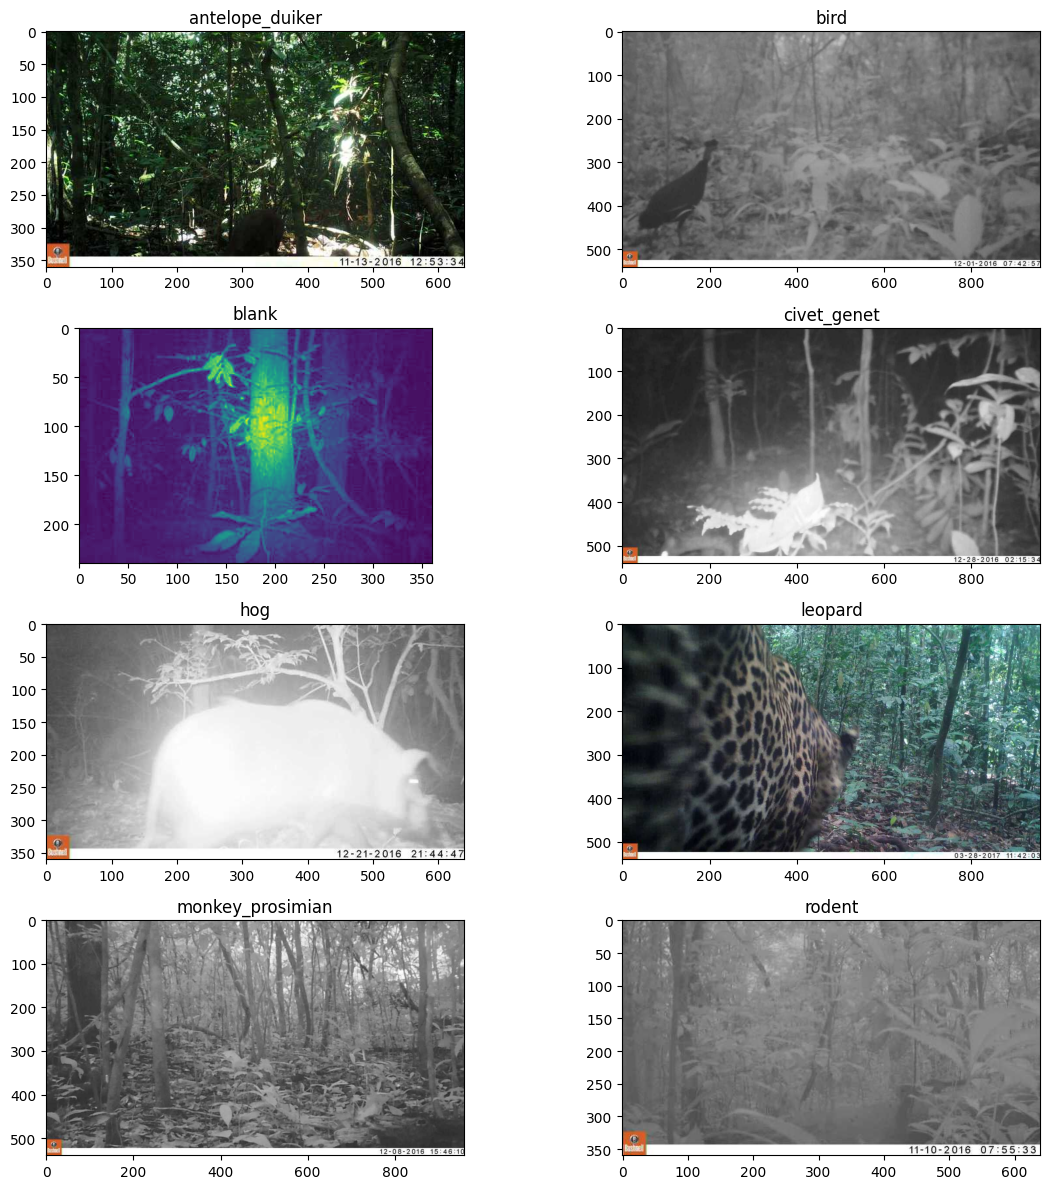

In [9]:
fig, axes = plt.subplots(4, 2, figsize = (12,12))
axes = axes.flatten()

for i, species in enumerate(train_labels.columns):
    photo_id = train_labels[train_labels[species] == 1].sample(1, random_state = 2).index[0]
    
    img_path = "data/" + train_features.loc[photo_id].filepath
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].set_title(species)

plt.tight_layout()
plt.show()


It would also be quite interesting to see how many animals appear in the photos. It may be the case that some species appear more frequently than others, which would bias the model towards better classifying those species.

In [10]:
train_labels.sum(axis=0).reset_index().rename(columns={"index":"species", 0:"number_images"})

,species,number_images
0,antelope_duiker,2474.0
1,bird,1641.0
2,blank,2213.0
3,civet_genet,2423.0
4,hog,978.0
5,leopard,2254.0
6,monkey_prosimian,2492.0
7,rodent,2013.0


In [11]:
(round(train_labels.sum(axis=0)/len(train_labels),4)*100).reset_index().rename(columns={"index":"species", 0:"percentage_images"})

,species,percentage_images
0,antelope_duiker,15.00
1,bird,9.95
2,blank,13.42
3,civet_genet,14.70
4,hog,5.93
5,leopard,13.67
6,monkey_prosimian,15.11
7,rodent,12.21


<Axes: ylabel='Frequency (%)'>

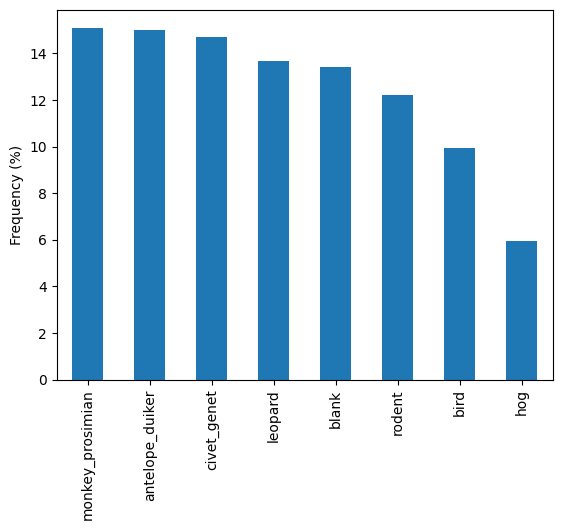

In [12]:
(round(train_labels.sum(axis=0)/len(train_labels),4)*100).sort_values(ascending=False).plot(ylabel="Frequency (%)", kind = "bar")

As is evident, the data set is not all too balanced. Each species (plus the "blank" class) should appear roughly 12.5% of the time. Here, however, some species only appear ~6% of the time (hog), while others appear in over 15% of the images (prosimian monkey).

Apart from the species, it is also important to see at which sites the images were taken. As can be seen, the number of images taken a some sites is vastly greater than at other sites (e.g. S0060 vs S0190). This will need to be taken into account not only during the model training phase, but also when splitting the data into the training and validation set.

In [13]:
train_features["site"].value_counts()

site
S0060    1132
S0009     664
S0063     557
S0008     541
S0036     456
         ... 
S0143       3
S0078       2
S0079       2
S0178       2
S0102       1
Name: count, Length: 148, dtype: int64

In [14]:
train_features["site"].value_counts(normalize=True)

site
S0060    0.068656
S0009    0.040272
S0063    0.033782
S0008    0.032812
S0036    0.027656
           ...   
S0143    0.000182
S0078    0.000121
S0079    0.000121
S0178    0.000121
S0102    0.000061
Name: proportion, Length: 148, dtype: float64

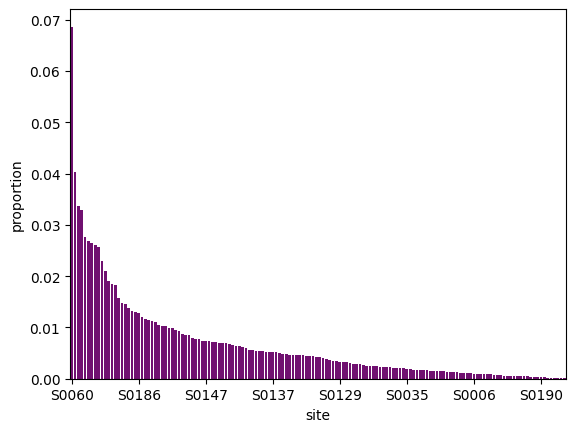

In [15]:
g = sns.barplot(data = train_features["site"].value_counts(normalize=True).reset_index(), x = "site", y = "proportion", color = "purple")
g.set_xticks(list(range(0, len(train_features["site"].value_counts()), 20)))

### Train-validation split

In [16]:
site_counts = train_features["site"].value_counts().sort_values(ascending=False).reset_index()
site_counts

,site,count
0,S0060,1132
1,S0009,664
2,S0063,557
3,S0008,541
4,S0036,456
...,...,...
143,S0143,3
144,S0078,2
145,S0079,2
146,S0178,2


As was pointed out, the distribution of images taken at each sites varies considerably (1132 images at the most frequent site vs. 1 image at the least frequent site). Randomly selecting sites for the training and validation set, where neither of them contain images from the same site, therefore replicates a real-life situation where camera traps are set up in entirely new locations. Since no other information is avaiable about the sites, except the site id, the sites did not serve as an additional input variable (feature), but were instead used to split the dataset into train and validation sets, each containing images from exclusive sites. 

Moreover, the split was also stratified by species. In order to achieve that, the train_feature and train_label dataframes were merged on the index and then grouped by site. After that, the number of images for each species was calculated by site. A new column with the most frequent species count for each site was created in order to stratify the train-validation split by species.

In [17]:
X_train, X_val, y_train, y_val = stratified_train_val_split(train_features, train_labels)

While the stratification isn't perfect, the results below show a relatively similar distributions of species between the training and validation set.

In [18]:
pd.DataFrame({"train":y_train.idxmax(axis = 1).value_counts(normalize=True), 
              "validation":y_val.idxmax(axis = 1).value_counts(normalize=True)})

,train,validation
antelope_duiker,0.158133,0.123709
bird,0.098684,0.102273
blank,0.137048,0.125000
civet_genet,0.157419,0.112862
hog,0.053266,0.079029
leopard,0.130152,0.158058
monkey_prosimian,0.153773,0.142562
rodent,0.111525,0.156508


The sites between the training and test dataset are disjoint, meaning that no site appears in both sets.

In [19]:
set(X_val["site"].unique()).isdisjoint(set(X_train["site"].unique()))

True

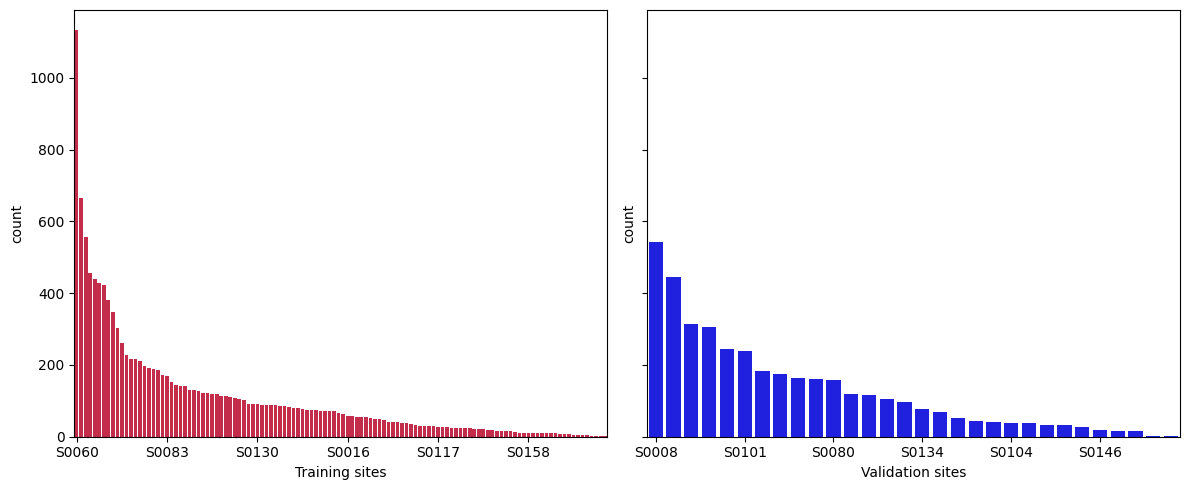

In [20]:
site_distributions(X_train, X_val, normalize = False)

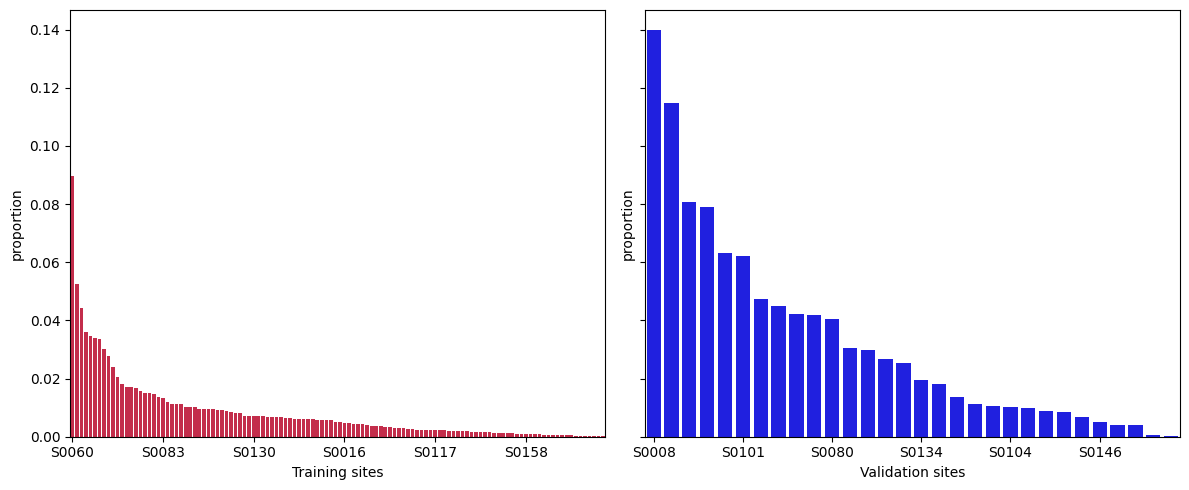

In [21]:
site_distributions(X_train, X_val, normalize = True)

The distribution of the number of images based on site location is not too similar between the train and validation set. The training set, admittedly, contains most of the sites with the highest number of images, which might skew the results later on. Achieving exlusive sites in both datasets, while stratifying based on species and, at the same time, having a roughly similar distribution of images taken at each site between the training and validation set, is a fine balancing act. For now, all these factors are relatively in sync and the training and validation datasets will be used as such.

In terms of the relative distribution (proportion), the most frequent sites in the validation dataset account for a bigger percentage compared to those in the training dataset. This makes sense, since the validation set contains only ~23% of the total sites.

## Transfer Learning with CNN

Transfer Learning is a machine learning method where a model already developed for a task is reused in another task. There are currently hundreds of different state-of-the-art pre-trained CNN models that can be used as benchmarks for other tasks, even if they are quite different from the original tasks. This way, the training process is generally narrowed down to the final, fully connected layers, which is how this model will be trained. 

### Loading the model

As a good starting point is the DenseNet201 model, which was trained on the ImageNet dataset, containing over 14 million annotated images. Other models, such as EfficientNetV2, will also be applied to compare results with the DenseNet201 base model.

In [22]:
from tensorflow.keras.applications.efficientnet_v2 import decode_predictions as decode_predictions_env2

# from tensorflow.keras.applications.efficientnet_v2 import preprocess_input 
    # prepocess_input not needed: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/preprocess_input

In [23]:
from tensorflow.keras.applications.densenet import decode_predictions as decode_predictions_dn201
from tensorflow.keras.applications.densenet import preprocess_input as prepro_input_dn201

In [24]:
densenet_base = keras.applications.DenseNet201(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

In [25]:
# efficientnet_base = keras.applications.EfficientNetV2L(weights='imagenet', include_top = False)

In [26]:
# Location of downloaded pre-trained models

!ls -sh ~/.keras/models/*.h5

 72M /c/Users/Flatko/.keras/models/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5
457M /c/Users/Flatko/.keras/models/efficientnetv2-l.h5
452M /c/Users/Flatko/.keras/models/efficientnetv2-l_notop.h5
528M /c/Users/Flatko/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5
 57M /c/Users/Flatko/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [27]:
densenet_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

Here, the convolutional layers are frozen and will not be trained upon.

In [28]:
for layers in densenet_base.layers[:]: 
    layers.trainable = False

In [29]:
# to unfreeze the last 2 layers, for example:
    # efficientnet.layers[-2:].trainable = True

### Loading images and transforming them to 4D tensors

Before the models are applied, the images need to be loaded and transformed into a format that the algorithm can read - namely 4D tensors. The 4 dimensions of these tensors are:

1. Number of images
2. Number of pixels along the width of the image
3. Number of pixels along the height of the image
4. Number of color bands - for colored images the number is usually 3 (red, green, blue)

For easier and faster loading of the dataset, it is common practice for each class (species) to have its own subfolder where the corresponding images are stored. The function "create_species_directory" takes care of that step.

In [ ]:
home_path = r"C:/Users/Flatko/MyGitRepos/drivendata-Conser-vision-Image-Classification/data/"

In [ ]:
create_species_directory(df_train = y_train, df_val = y_val, home_path = home_path)

Now, the images for both the training and the validation set can be loaded and directly tranformed into a numpy array. Specifying the batch size to be 128 prevents bottlenecks in the memory and greatly speeds up the process. The array contains each image's pixel values in each of the three color bands (red, green, blue). 

In [240]:
train = keras.utils.image_dataset_from_directory(directory = "data/train",
                                               batch_size = 128,
                                               image_size = (224,224))

val = keras.utils.image_dataset_from_directory(directory = "data/valid",
                                               batch_size = 128,
                                               image_size = (224,224))

Found 12616 files belonging to 8 classes.
Found 3872 files belonging to 8 classes.


In [241]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [69]:
#image_paths_train = [f"data/{img_path}" for img_path in X_train["filepath"]]
#image_paths_val = [f"data/{img_path}" for img_path in X_val["filepath"]]
#image_paths_test = [f"data/{img_path}" for img_path in test_features["filepath"]]

Applying a custom function, the images have been transformed into 4D tensors with custom dimensions (224x224).

In [73]:
#train_img = paths_to_tensor(image_paths_train, size_x = 224, size_y = 224)
#val_img = paths_to_tensor(image_paths_val, size_x = 224, size_y = 224)
#test_img = paths_to_tensor(image_paths_test, size_x = 224, size_y = 224)

100%|██████████| 4464/4464 [00:20<00:00, 214.90it/s]


In [96]:
#train_img.shape, val_img.shape, test_img.shape

((12616, 224, 224, 3), (3872, 224, 224, 3), (4464, 224, 224, 3))

Some pre-trained models, such as DenseNet201, require the data to be additionally preprocessed. From the DenseNet201 Tensorflow documentation page: "The input pixels values are scaled between 0 and 1 and each channel is normalized with respect to the ImageNet dataset." In the end, the result of the preprocessing yields values typically between -1 and 1.

In [195]:
train_densenet = train.map(lambda x, y: (prepro_input_dn201(x), y))
val_densenet = val.map(lambda x, y: (prepro_input_dn201(x), y))

In [ ]:
#train_img_densenet = prepro_input_dn201(train_img)
#val_img_densenet = prepro_input_dn201(val_img)

#### Weighting classes

When dealing with unbalanced distributions of target classes, it can sometimes be beneficial to apply weights to under-represented species in the classifier. This can be done by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to images from under-represented classes.

Here's a reminder of the distribution of species in the training dataset.

In [34]:
y_train.idxmax(axis = 1).value_counts(normalize = False).reset_index().sort_values(by = "index")

,index,count
0,antelope_duiker,1995
6,bird,1245
3,blank,1729
1,civet_genet,1986
7,hog,672
4,leopard,1642
2,monkey_prosimian,1940
5,rodent,1407


And here are the corresponding weights that will be applied in the loss function. In the context of this problem, cross-entropy is used as the loss function. Here's how the weights were calculated for any given class:

${weight_i} = \left(\frac{1}{\text{number of images in class {i}}}\right) \times \left(\frac{\text{total number of images}}{\text{number of classes}}\right)$

In [149]:
class_weights = compute_class_weight(class_weight="balanced", classes = np.array(y_train.columns), y = y_train.idxmax(axis = 1))
dict_weights = dict(zip(y_train.columns, class_weights))

pd.DataFrame(dict_weights, index = [0])

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.790476,1.266667,0.912088,0.794058,2.346726,0.960414,0.812887,1.120824


In [231]:
dict_weights_numbers = {{list(dict_weights.keys())[i]: list(range(8))[i] for i in range(len(list(dict_weights.keys())))}[old_key]: value for old_key, value in dict_weights.items()}

### Creating the model

The DenseNet201 model will now be fine-tuned to fit to the dataset by editing the last few layers.

**Cross-validation with hyperparameter tuning**

In the section below, the following hyperparameters are being tuned:

* Number of epochs
* Batch size
* Learning rate and learning decay
* Number of hidden units (nodes)
* L2 Regularization
* Dropout layer rate
* Initial kernel values
* Optimizers (Adam, RMSprop, SGD (with and without momentum))

In [ ]:
def model_densenet (hp = keras_tuner.HyperParameters(), seed = 65):
    
    #defining model 

    K.clear_session()
    
    model = Sequential()

    model.add(densenet_base)

    model.add(Flatten())
    model.add(BatchNormalization())


    model.add(Dense(units = hp.Choice("units_1", [8, 16, 32, 64, 128, 256]), 
                    kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                    kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_1", min_value=1e-4, max_value=1e-1, sampling = "log")), 
                    name = "dense1"))
    if hp.Boolean("dropout_layer"):
        model.add(Dropout(rate = hp.Float("dropout_rate_1", min_value = 0, max_value = 1, step = 0.1), seed = seed))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


   # Layer 2

    model.add(Dense(units = hp.Choice("units_2", [8, 16, 32, 64, 128, 256]), 
                    kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                    kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_2", min_value=1e-4, max_value=1e-1, sampling = "log")), 
                    name = "dense2"))
    if hp.Boolean("dropout_layer"):
        model.add(Dropout(rate = hp.Float("dropout_rate_2", min_value = 0, max_value = 1, step = 0.1), seed = seed))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))

    
    # Layer 3 

    model.add(Dense(units = hp.Choice("units_3", [8, 16, 32, 64, 128, 256]), 
                    kernel_initializer = hp.Choice("kernel_init", ["uniform", "glorot_uniform", "glorot_normal"]),
                    kernel_regularizer = keras.regularizers.L2(hp.Float("kernel_reg_3", min_value=1e-4, max_value=1e-1, sampling = "log")), 
                    name = "dense3"))
    if hp.Boolean("dropout_layer"):
        model.add(Dropout(rate = hp.Float("dropout_rate_3", min_value = 0, max_value = 1, step = 0.1), seed = seed))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice("activation", ["relu","gelu","selu"])))


    model.add(Dense(units = 8, activation = "softmax", name = "output"))



    #compiling model

    epochs = hp.Int("epochs", min_value = 10, max_value = 100)
    batch_size = hp.Choice("batch_size", [32, 64, 128, 256, 512])


    lr = hp.Float("lr", min_value = 1e-4, max_value = 1e-1, sampling = "log")
    
    sgd_momentum = hp.Float("momentum", min_value = 0.8, max_value = 0.95)

    optimizers_dict = {
        "adam":    keras.optimizers.Adam(learning_rate = lr),
        "sgd":     keras.optimizers.SGD(learning_rate = lr, momentum = sgd_momentum),
        "rmsprop": keras.optimizers.RMSprop(learning_rate = lr)
        }

    hp_optimizers = hp.Choice('optimizer', values=["adam", "sgd", "rmsprop"])


    model.compile(optimizer = optimizers_dict[hp_optimizers], metrics = ["accuracy", 
                                                                         "f1_score",
                                                                         keras.metrics.Recall(name = "recall"),
                                                                         keras.metrics.Precision(name = "precision"),
                                                                         keras.metrics.AUC(name = "AUC")
                                                                         ], 
                  loss = tf.keras.losses.SparseCategoricalCrossentropy())

    return model

In [233]:
model_densenet()

In [234]:
seed = 65

optimize_densenet = keras_tuner.BayesianOptimization(hypermodel = model_densenet,
                                                     objective = "val_accuracy",
                                                     max_trials = 30,
                                                    overwrite = True,
                                                     seed = seed)

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, verbose = 1)

In [216]:
seed = 65

optimize_densenet = keras_tuner.tuners.SklearnTuner(oracle = keras_tuner.oracles.BayesianOptimizationOracle( 
                                                                                            objective = keras_tuner.Objective("score","max"), 
                                                                                              max_trials = 30,
                                                                                              seed = seed
                                                                                              ),
                                                    hypermodel = model_densenet,
                                                    scoring = metrics.make_scorer(metrics.accuracy_score),
                                                    cv = KFold(n_splits = 5)
                                                    )


In [ ]:
optimize_densenet.search(train_densenet, validation_data = val_densenet, class_weights = dict_weights_numbers, callbacks = [es], verbose = 1)

In [ ]:
optimize_densenet.search(train_img_densenet, y_train)

In [ ]:
best_hps_densenet = optimize_densenet.get_best_hyperparameters(num_trials = 1)

In [ ]:
best_model_densenet = optimize_densenet.hypermodel.build(best_hps_densenet)

In [ ]:
training_history = {}


training_history["densenet_base"] = best_model_densenet.fit(train_densenet, validation_data = val_densenet, callbacks = [es],
                                                            class_weight = dict_weights_numbers, verbose = 1)

In [63]:
def plot_metric(history, metric = "accuracy", val_metric = "val_accuracy"):
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
plot_metric(training_history["densenet_base"])

In [64]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss (Cross Entropy)')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(training_history["densenet_base"])

**Predictions and evaluation on the validation set**

In [ ]:
y_pred = best_model_densenet.predict(val_img_densenet)

In [ ]:
decode_predictions_dn201(y_pred)

In [ ]:
print(classification_report(y_pred = y_pred, y_true = y_val))

In [ ]:
mat = print(confusion_matrix(y_pred = y_pred, y_true = y_val))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**ROC Curve and Area Under Curve (AUC) score**

In [ ]:
!mkdir -p saved_model
best_model_densenet.save('saved_model/densenet')

### Image Augmentation

Apart from applying different weights to under-represented classes, there are a number of additional techniques which can be leveraged to balance out the distribution among species. 

* Undersampling is a technique based around removing images from the dataset until the distribution of classes is equalized. 
* Likewise, oversampling is almost the exact opposite of undersampling, except it randomly duplicates the underrepresented classes until there is a balance.
* In this case, a technique called Image Augmentation is used. It is similar to oversampling, but rather than introducing duplicates to the data, the process augments the images in some way. Examples include shifting of images in any direction, zoom in or out, rotating or flipping.

Image augmentation techniques also have additional benefits apart from balancing out the class distributions. Because the animals in the invidiual images are not always in the center of the picture, but sometimes appear too far to the left, or are simply too close to the camera, image transformations help level the playing field and make it therefore easier for the model to better predict the different variations of images that exist in the dataset.

The ImageDataGenerator class from Keras is called to instantiate the image augmentation process. The following changes will be applied to images:

* Rotation
* Shearing
* Shifts along the width and height
* Zooming in and out
* Different brightness levels
* Horizontal flip

In [83]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.4,1.5],
        horizontal_flip=True,
        preprocessing_function = prepro_input_dn201,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(
        preprocessing_function = prepro_input_dn201)

In [32]:
image_nr = 34

i = 0
for batch in train_datagen.flow(train_img[image_nr].reshape((1,) + train_img[42].shape), batch_size=1,
                          save_to_dir='preview', save_prefix='image', save_format='jpeg'):
    i += 1
    if i > 40:
        break

In [79]:
train_densenet_augmented = train_datagen.flow_from_directory(
        directory = 'data/train',
        batch_size = 128,
        classes = y_train.columns.to_list(),
        class_mode='categorical',
        target_size=(224, 224)) 

val_densenet_augmented = val_datagen.flow_from_directory(
        directory='data/valid',
        batch_size = 128,
        classes=y_train.columns.to_list(),
        class_mode="categorical",
        target_size=(224, 224))

Found 12616 images belonging to 8 classes.
Found 3872 images belonging to 8 classes.


In [80]:
train_densenet_augmented.class_indices

{'antelope_duiker': 0,
 'bird': 1,
 'blank': 2,
 'civet_genet': 3,
 'hog': 4,
 'leopard': 5,
 'monkey_prosimian': 6,
 'rodent': 7}

In [81]:
train_densenet_augmented.image_shape

(224, 224, 3)

In [ ]:
seed = 65

optimize_densenet_augmented = keras_tuner.BayesianOptimization(hypermodel=model_densenet,
                                                     objective = "val_accuracy",
                                                     max_trials = 30,
                                                    overwrite = True,
                                                     seed = seed)


In [ ]:
optimize_densenet_augmented.search(train_densenet_augmented, validation_data = val_densenet_augmented, 
                                   callbacks = [es], class_weights = dict_weights, verbose = 1)

In [ ]:
best_hps_densenet_aug = optimize_densenet_augmented.get_best_hyperparameters(num_trials = 1)

In [ ]:
best_model_densenet_aug = optimize_densenet_augmented.hypermodel.build(best_hps_densenet_aug)

In [ ]:
training_history = {}


training_history["densenet_base_aug"] = best_model_densenet_aug.fit(train_densenet_augmented, validation_data = val_densenet_augmented, callbacks = [es],
                                                            class_weight = dict_weights, verbose = 1)

In [ ]:
def plot_metric(history, metric = "accuracy", val_metric = "val_accuracy"):
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
plot_metric(training_history["densenet_base_aug"])

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss (Cross Entropy)')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(training_history["densenet_base_aug"])

**Predictions and evaluation on the validation set**

In [ ]:
y_pred_aug = best_model_densenet_aug.predict(val_densenet_augmented)

In [ ]:
decode_predictions_dn201(y_pred_aug)

In [ ]:
print(classification_report(y_pred = y_pred_aug, y_true = y_val))

In [ ]:
mat = print(confusion_matrix(y_pred = y_pred_aug, y_true = y_val))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**ROC Curve and Area Under Curve (AUC) score**

In [ ]:
!mkdir -p saved_model
best_model_densenet_aug.save('saved_model/densenet_aug')